# Purpose

The purpose of this notebook is to show the final model that could predict sale prices in King County. 
The data was taken from the 2019 home and was used to answer the following:
1.)Does higher square footage increases home sale price? 
2.)Does having a porch increases home sale price? 
3.)Does Having a beachfront or lakefront increases home sale price?

In [ ]:
# To download the King county files used in this project use the following bash commands:
! wget -P ../../src/data/https:// <https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip>
! wget -P ../../src/data/https:// <https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip>
! wget -P ../../src/data/https:// <https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip>

In [ ]:
# Then run these commands to unzip the files:
! unzip ../../src/data/<Real Property Sales.zip>
! unzip ../../src/data/<Residential Building.zip>
! unzip ../../src/data/<Parcel.zip>

In [30]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.mymods import correlation_info, model_summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing Dataframe

In notebooks/exploratory/DataFilering.ipynb we filterd for homes sold in 2019 that were sold for over 250K and less than 3M. Its saved as combined_onehot.json.

In [24]:
df = pd.read_json('../../src/data/combined_onehot.json')

The function below takes a data frame, target variable, and the minimum correlation to give us a heat map and a list of the features. We originally set our correlation higher, but we realized to get an answer to whether waterfront properties increase we needed to set it lower.

The function takes a dataframe, target variable, and list of features and returns a summary. Currently the results of this are not scaled at all. 

['SqFtTotLiving',
 'SqFtOpenPorch',
 'FinBasementGrade',
 'WfntLocation_6.0',
 'WfntLocation_7.0',
 'WfntFootage',
 'WfntLocation_3.0',
 'WfntLocation_8.0',
 'WfntLocation_5.0']

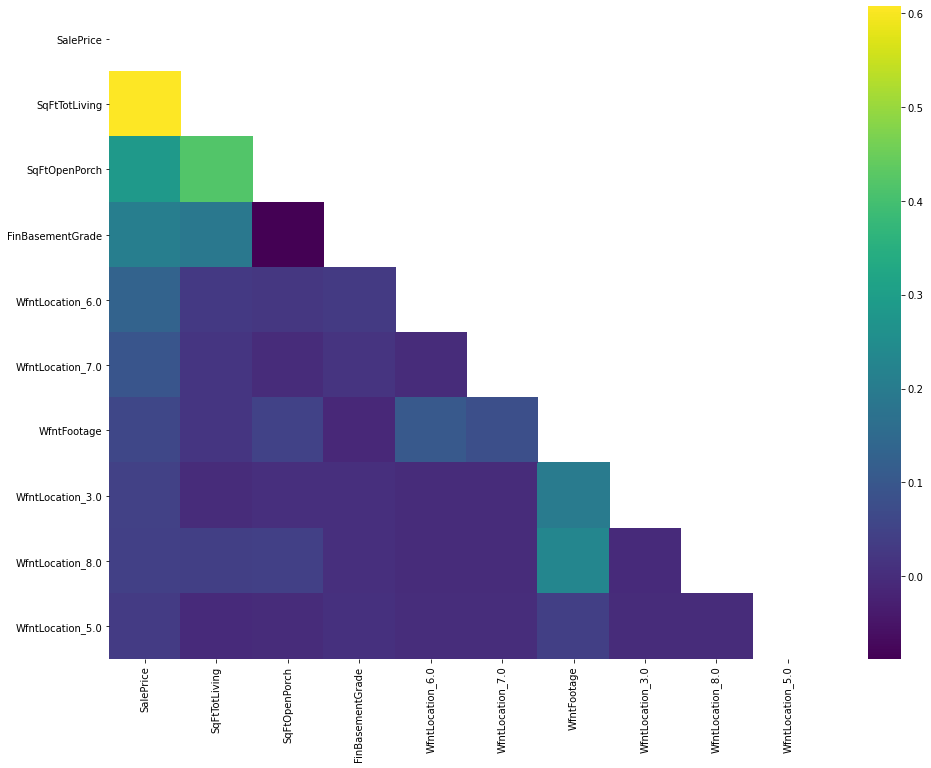

In [25]:
top_corr, graph = correlation_info(df, 'SalePrice',.01)
top_corr

From the heat map you can see the most correlated to sale price. Squarefootage of total living is the highest correlated which is what we would have expected. 

In [31]:
summary, third_model = model_summary(df,'SalePrice', top_corr)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                          1.722e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        09:41:53   Log-Likelihood:                     -3.6602e+05
No. Observations:               25903   AIC:                                  7.321e+05
Df Residuals:                   25894   BIC:                                  7.321e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
SqFtTotLiving      318.8279      1.431    222.727      0.000     316.022     321.634
SqFtOpenPorch      125.3265     19.153      6.544      0.000      87.786     162.867
FinBasementGrade  1.392e+04    591.052     23.559      0.000    1.28e+04    1.51e+04
WfntLocation_6.0      1e+06   4.64e+04     21.573      0.000    9.09e+05    1.09e+06
WfntLocation_7.0  1.238e+06   7.45e+04     16.621      0.000    1.09e+06    1.38e+06
WfntFootage        334.4771    101.484      3.296      0.001     135.562     533.392
WfntLocation_3.0  3.566e+05   3.73e+04      9.572      0.000    2.84e+05     4.3e+05
WfntLocation_8.0  9.215e+04   3.11e+04      2.959      0.003    3.11e+04    1.53e+05
WfntLocation_5.0  8.805e+05   1.25e+05      7.018      0.000    6.35e+05    1.13e+06
==============================================================================
Omnibus:                     5790.612   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25422.301
Skew:                           1.035   Prob(JB):                         0.00
Kurtosis:                       7.390   Cond. No.                     1.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## A look at Coefficients and $R^2$

Some of these coefficients are extremely high but it makes sense in terms of dollars. Water front location 6 is Lake Washington and it suggests if you have a house on that lake it will be an additional 1 million dollars in value. For every square foot of living you have it increases your homes sale price by 319. Our $R^2$ is pretty high accounting for 86% of the variance in selling price, but we need to see if it meets all the assumptions.

In [38]:
from IPython.display import Image

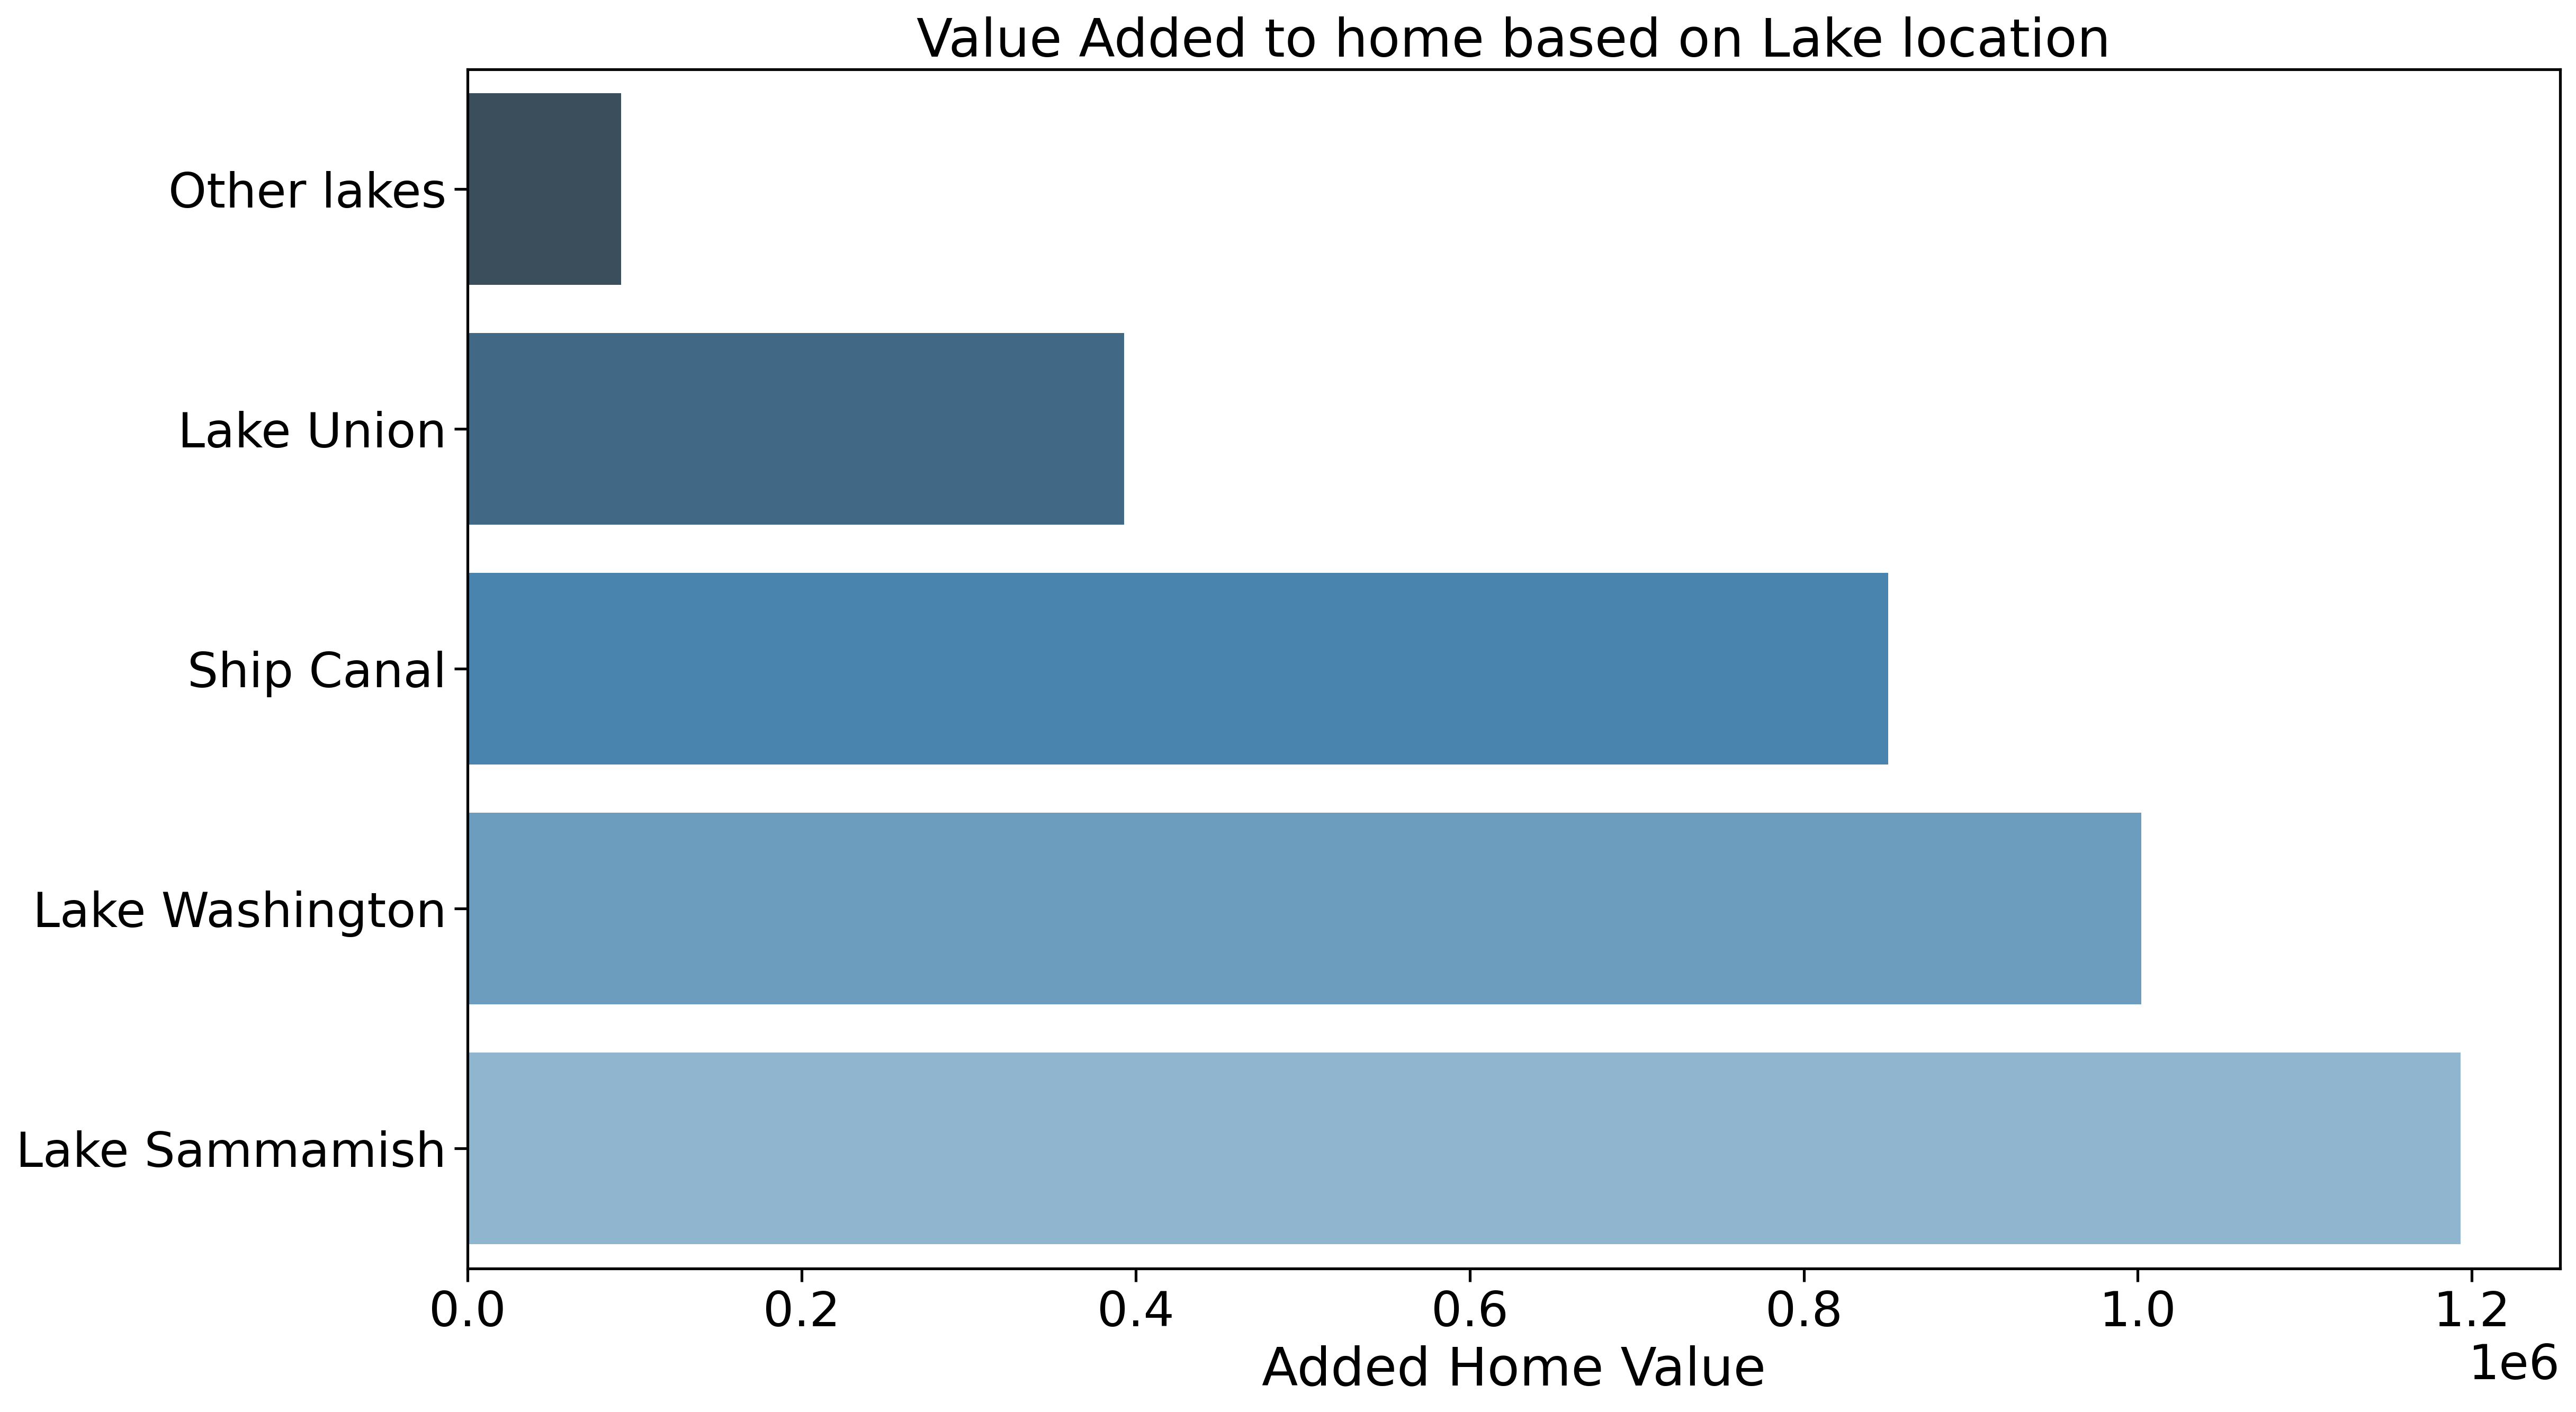

In [44]:
Image(filename = "Figures/waterlocation.png", width = 1000, height = 500)

Based on this model and graph we can see that Lake Sammamish and Lake washington will increase the value of your home by the greatest. Both of these lakes are large bodies of water and near Seattle and Bellevue areas which are exepensive. Other lakes accounting for more of the smaller lakes littered throughout King County will give you the least added value to your home with about 92K. 

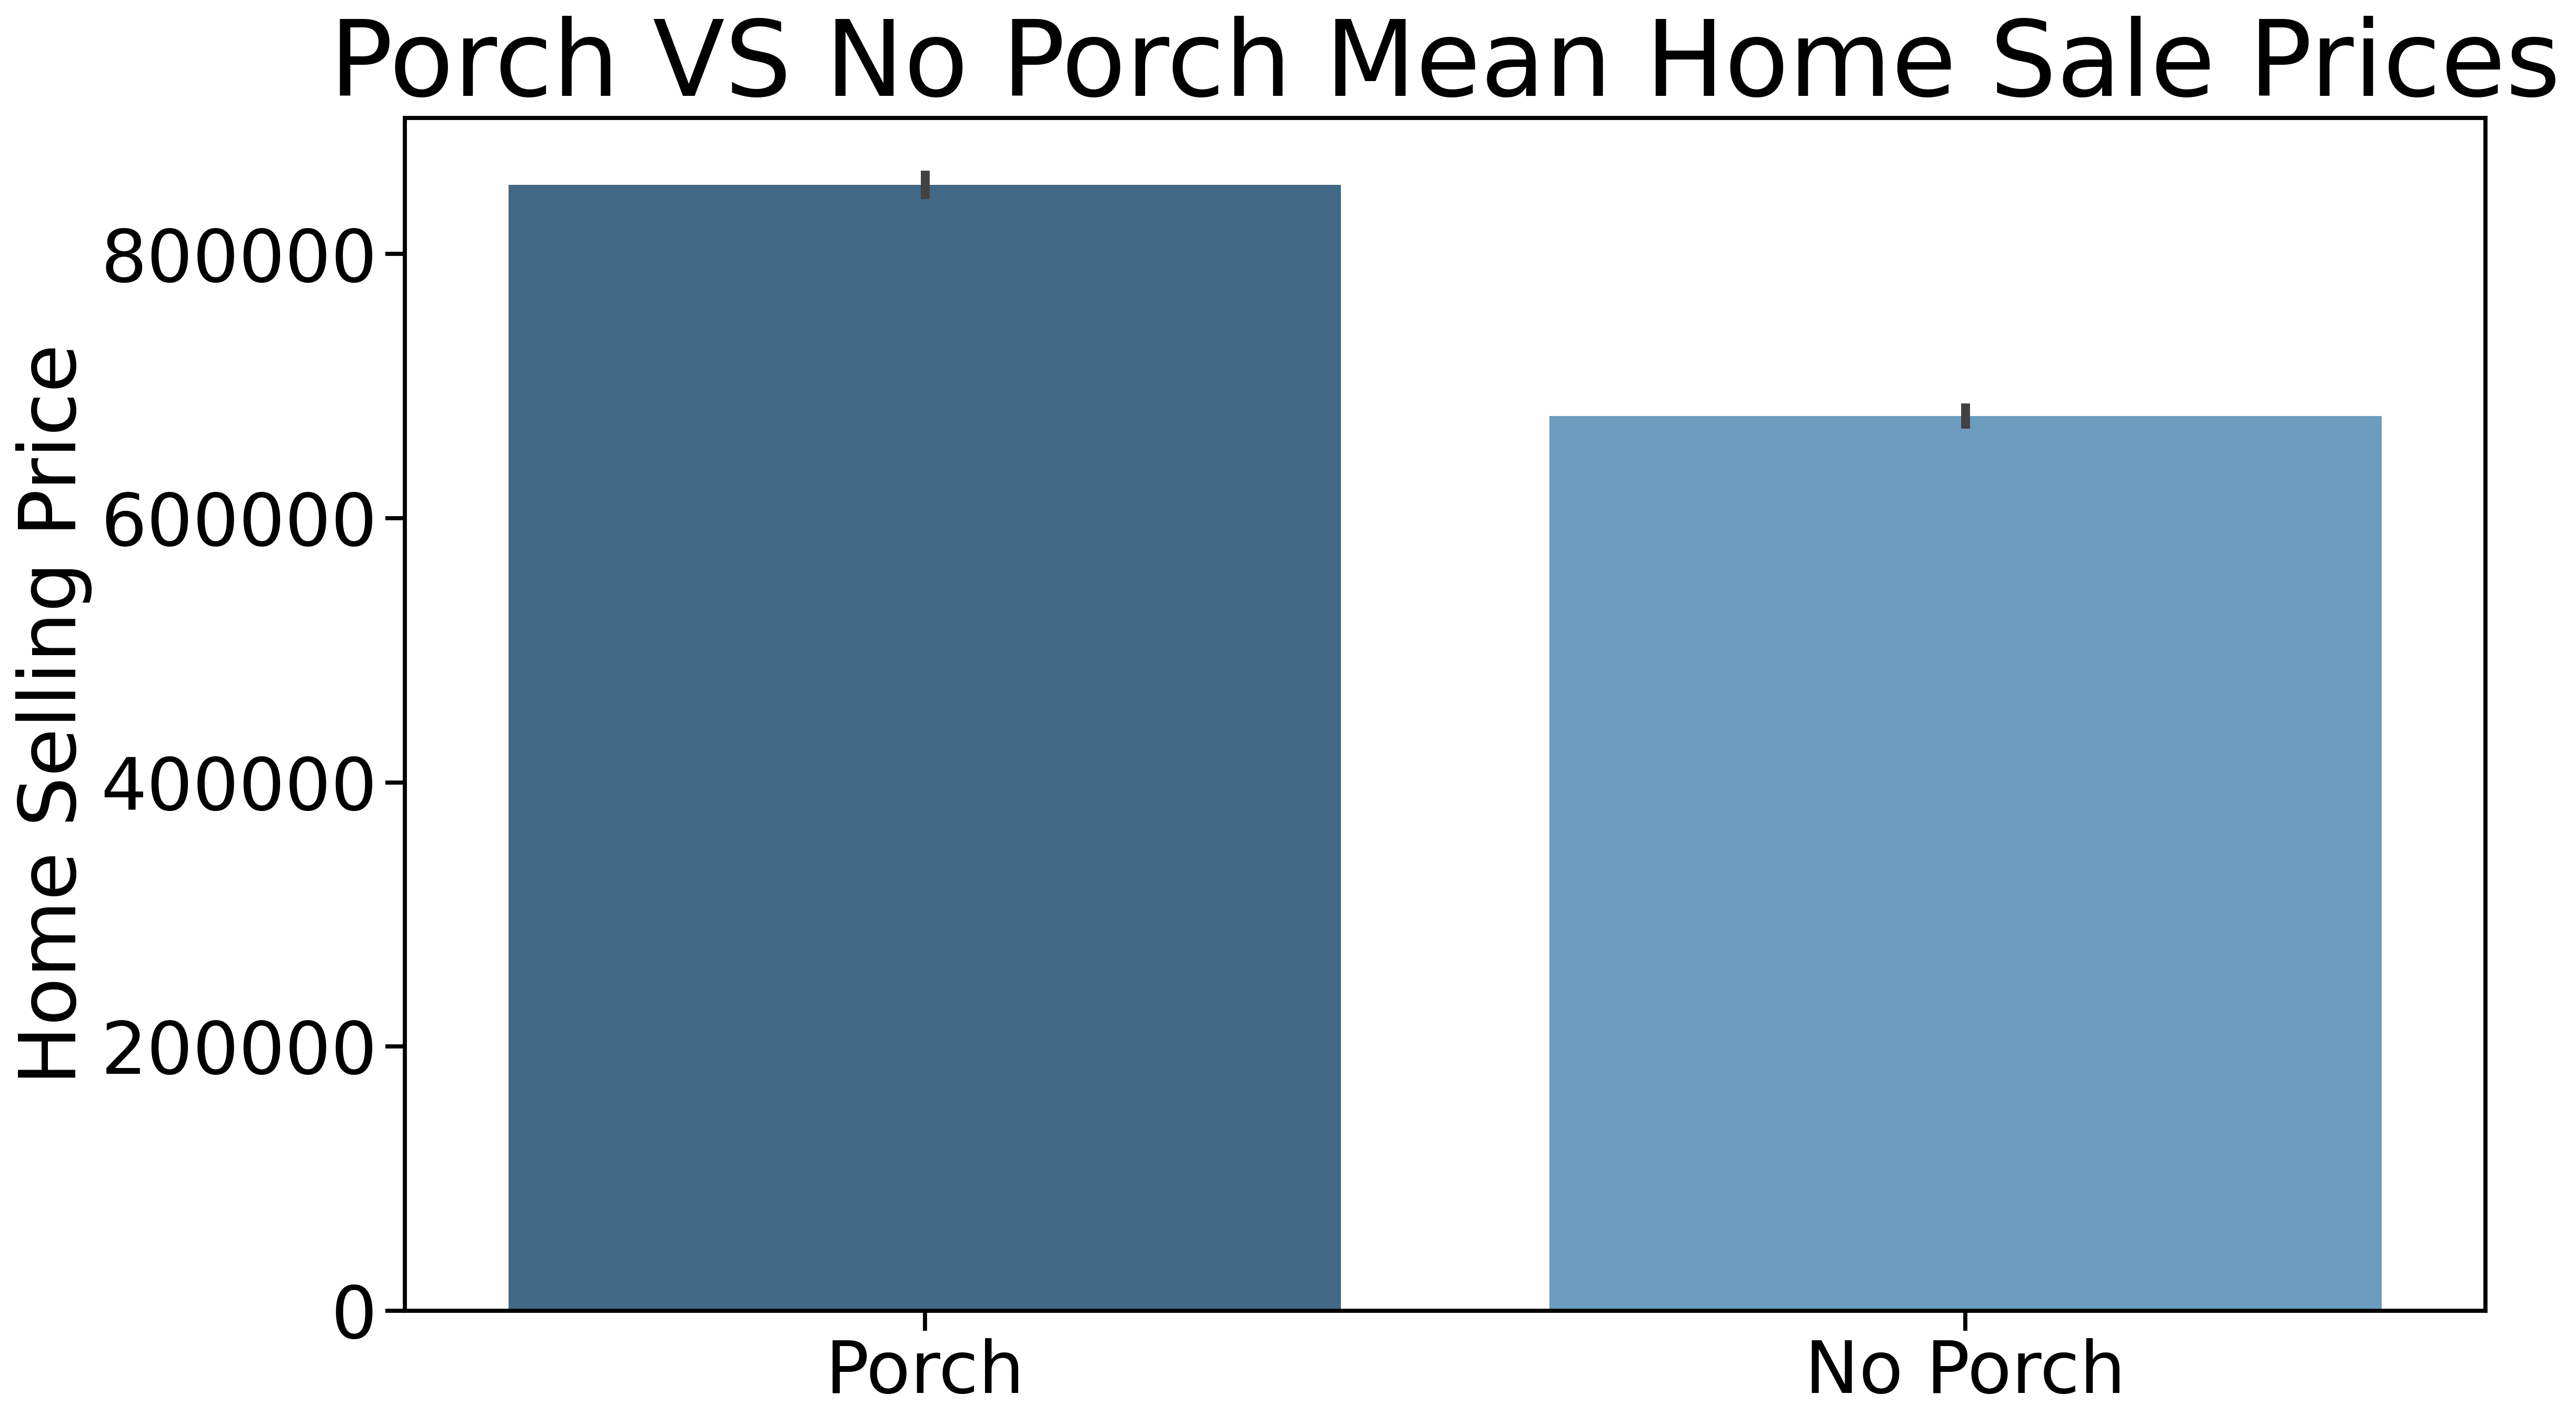

In [43]:
Image(filename = "Figures/Porch.png", width = 1000, height = 500)

Part of the reason we chose porch was because there about a 200K difference in sale prices between homes with a porch and homes without a porch as shown from the graph above. Our model tells us that for every squarefoot of porch the sale price of a house will increase by about 125$. 

### Linearity

In [112]:
rainbow_statistic, rainbow_p_value = linear_rainbow(third_model)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0023206849327422
Rainbow p-value: 0.4475429191934796


If we set our alpha to .05 the p-value is far greater than that meaning we are currently not violating Linearity assumtions. 

### Normality 

jarque_bera: 25422.30053352313
Prob(JB): 0.0


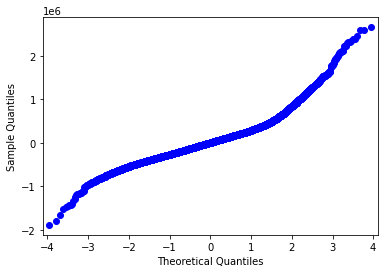

In [29]:
jarque_bera = list(sms.jarque_bera(third_model.resid))[0]
Prob_JB =list(sms.jarque_bera(third_model.resid))[1]
print(f'jarque_bera: {jarque_bera }')
print(f'Prob(JB): {Prob_JB}')

third_model_resids = third_model.resid
sm.qqplot(third_model_resids);

The Prob(JB) is showing as 0 which mean it is currently violating the Normality assumption. The QQ plot is showing this as well as it isnt a straight line and the left and right tails are curved. This is telling us that the random error between our independent variables and dependent variables is fairly large. One thng to improve this would be to take the outliers out of each predictors. 

### Homoscadasticity

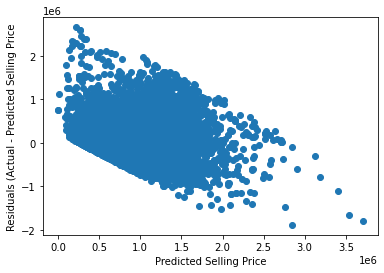

In [118]:
y_hat = third_model.predict()

fig, ax = plt.subplots()
ax.set(xlabel="Predicted Selling Price",
        ylabel="Residuals (Actual - Predicted Selling Price")
ax.scatter(y_hat, third_model_resids);

A look at the Homoscadasticity tells us that our model is undervaluing cheaper sold homes and over valueing more expensive homes. As the price increases the amount of outliers seem to increase as well. 

In [122]:
rows = df[top_corr].values

vif_df_third = pd.DataFrame()
vif_df_third["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(top_corr))]
vif_df_third["feature"] = top_corr

vif_df_third

,VIF,feature
0,2.668034,SqFtTotLiving
1,1.724453,SqFtOpenPorch
2,1.749981,FinBasementGrade
3,1.016200,WfntLocation_6.0
4,1.008621,WfntLocation_7.0
5,1.132020,WfntFootage
6,1.047656,WfntLocation_3.0
7,1.067224,WfntLocation_8.0
8,1.002226,WfntLocation_5.0


From the summary we had a contition number of 143,000 which is high, but from our VIF table you can see that none of the features are above 5 indicating we are not violating the independence assumptions. 

# Summary 

From this model we can say that it explains about 86% of the variance in selling price from 9 features. <br>
SqFtTotLiving (Square foot of house) increased the value of a home by 319 dollars per square foot. <br>
SqFtOpenPorch(Square foot of porch) increased the value of home by 125 dollars per square foot. <br>
FinBasementGrade(How Nice the Basement is) increased the value of the home by 13,900 dollars for each grade 1-12.<br>
WfntLocation(Which lake its on, dummy catagory) increased its value anywhere from 92,000 to 1,238,000 depending on which lake you were on<br>
WfntFootage(Square foot of waterfront property). for each squarefoot the value of the home increased by 334 dollars. <br>


Our task was to see if Waterfront property, square footage, and porch has an impact on the sales price of a home. Based on our model all those features imporve the sales price of the home. 

All these are statistically significant, but the next steps would be imporving the model by adding features or removing features so we can meet all the assumptions. 